# Support Vector Machines
Support Vector Machines (SVMs) are among the most powerful supervised algorithms. They support classification and resgression. Let's start with some standard import and continue with devoloping the intuition behind SVMs.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

SVMs operate by finding a seperation line that devides classes from each other.  

As an example we consider the following dataset:

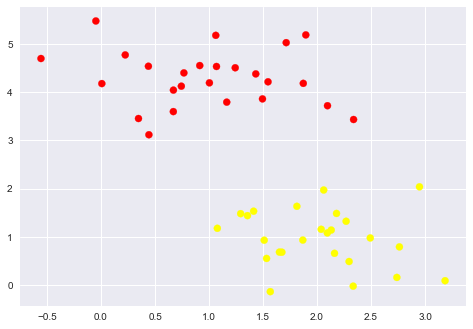

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Now the goal is to draw a straight line that seperates the two classes.  
But there are several ways to do this. Which one is the best?

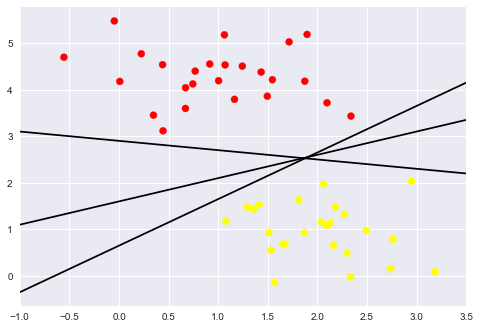

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

How should we classify new data? Depending on which line we choose, the label for the new data point varies.  

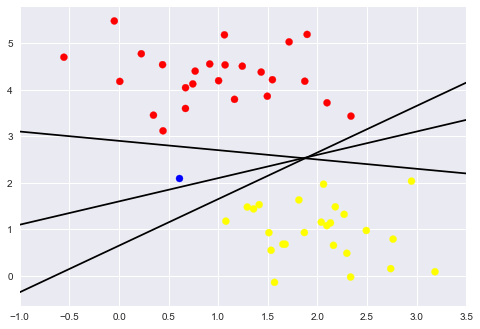

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.scatter([0.6], [2.1], color='blue')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

# Maximizing the margin

Support vector machines offer one way to improve on this.  
Rather than simply drawing a line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

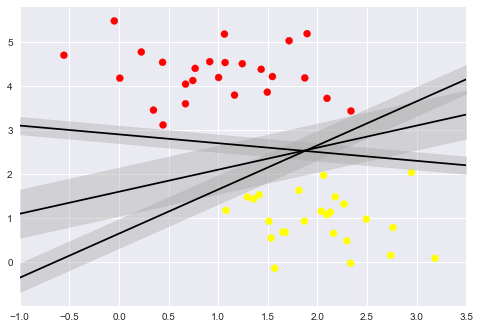

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

The line that maximizes this margin is the one we will choose as the optimal model.

## Fitting a SVM
SVMs requires Hyperparameter. We'll discuss them later.

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

For the purpose of this lecture, let's write a function that prints the decision boundries of a SVM

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolor='k');
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

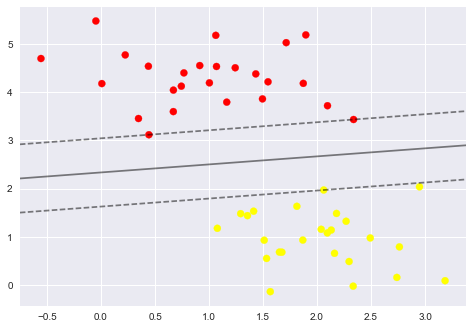

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, plot_support=False);

This is the line that maximizes the margin between the two classes.  
### Which datapoints are essential and define the boundry line?

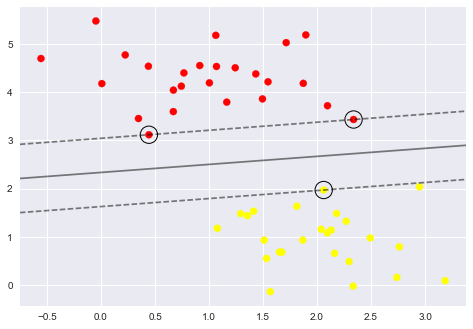

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, plot_support=True);

The black circles indicate the only relevant datapoints for the model.  
They are called _support vectors_. Hence, the name of the model. In Scikit-Learn these vectors are stored in:

In [10]:
model.support_vectors_

array([[ 0.44359863,  3.11530945],
       [ 2.33812285,  3.43116792],
       [ 2.06156753,  1.96918596]])

* For this model, only the position of the support vectors matters.
* The number of datapoints is irrelevant, as long as non of these crosses the margin lines

We can see this in the next example where similar datasets are plotted but with a varying number of datapoints.

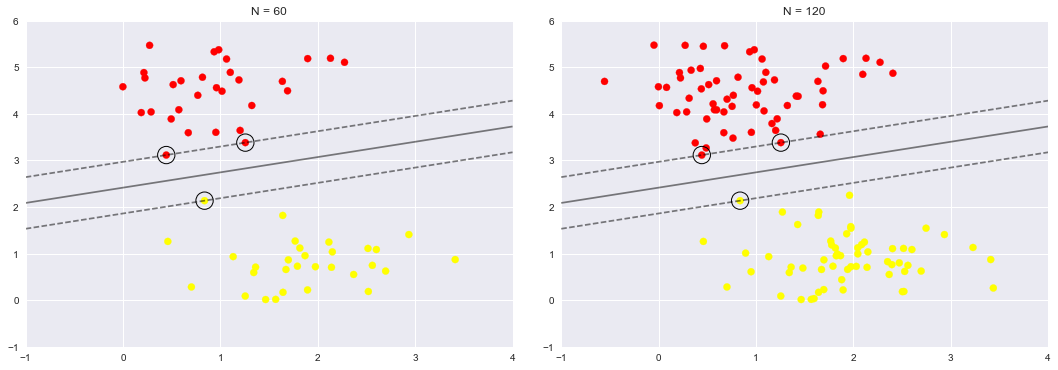

In [11]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

#### Although the dataset has changed, the support vectors remain the same.

## Interactive visualization

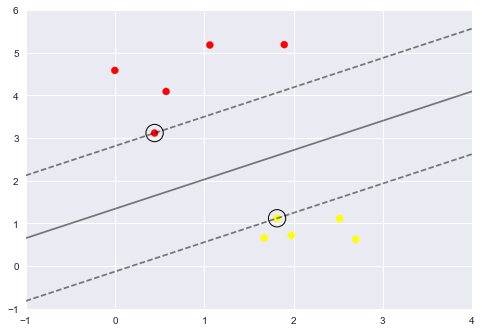

In [12]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

# Beyond linear boundries

SVMs become really powerful when they are combined with another idea: _kernels_.  
When a dataset is not linear seperable a kernel can transform the space to make linear seperable.

Consider the following dataset:

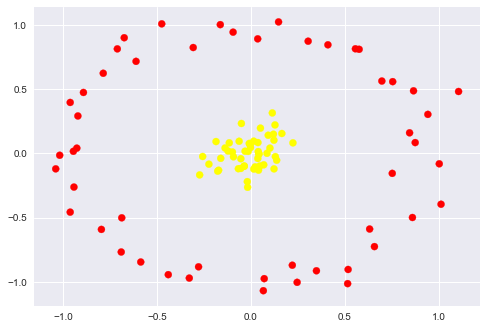

In [13]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

## Where should we put the boundry?

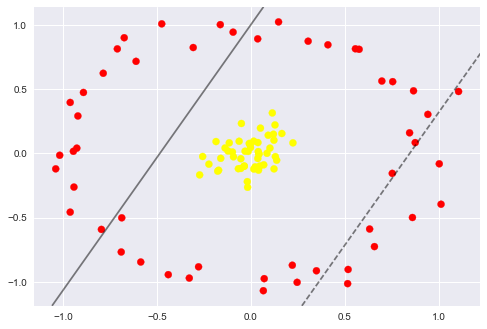

In [14]:
clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Obviously this dataset cannot be seperated by line, buth there is a obvious structure in the data.  
* So how could we make the data linear seperable?
* What is the difference between the yellow and the red class?

#### The distance to the center (0, 0) seems to be important.
We can exploit this insight by using the _radial basis function kernel_ to transform the input space.

In [15]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot:

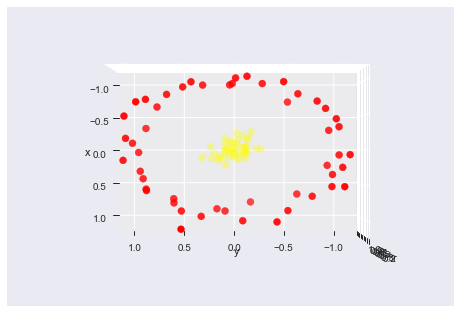

In [16]:
from mpl_toolkits import mplot3d

def plot_3D(elev=-90, azim=180, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azim=(-180, 180),
         X=fixed(X), y=fixed(y));

* Is the dataset now linear seperable? How?
* We've centered our kernel at (0, 0). Is that always wise?
* Alternatively we can center the RBF at any datapoint and see how well the SVM seperates the classes. This with the number of datapoints, which is bad. But the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) makes the additional effort irrelevant.

* The kernel trick is build into SVM class of Scikit-Learn.
* We can simply change the `kernel` parameter to use the RBF kernel

In [17]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

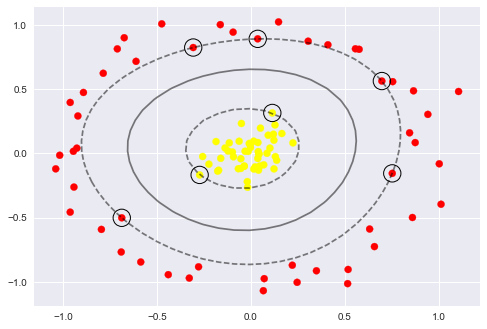

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

This trick no only applies to SVMs. It is used whenever a linear method must be transformed into a non-linear method. 

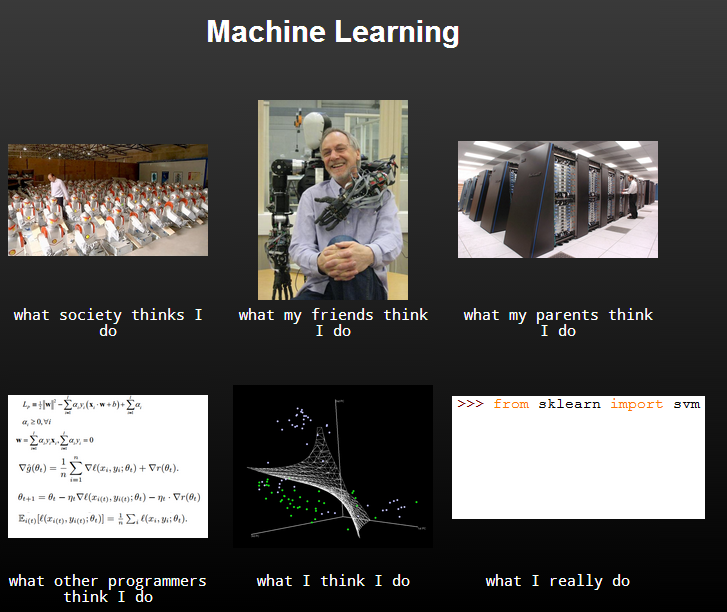

In [19]:
from IPython.display import Image
Image('images/machineLearning.png')

## Leaving the ideal world, entering the real world

Thus far we've only dealt with datasets where a perfect seperation could be found.  
In practice, this never happens. So let's consider the following dataset:

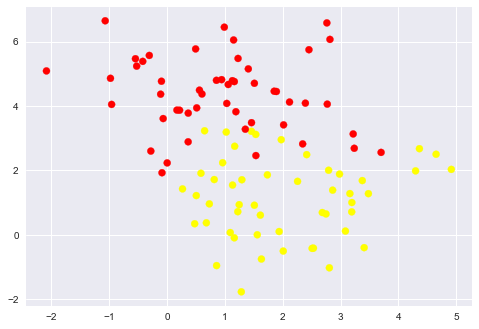

In [20]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Thus far we enforced a strict "no datapoint within the margins"-policy (by choosing a very high value $C$).  
The small we choose the values for $C$ the more datapoints are allowed in the margin.  
This plot depicts the influence of $C$:

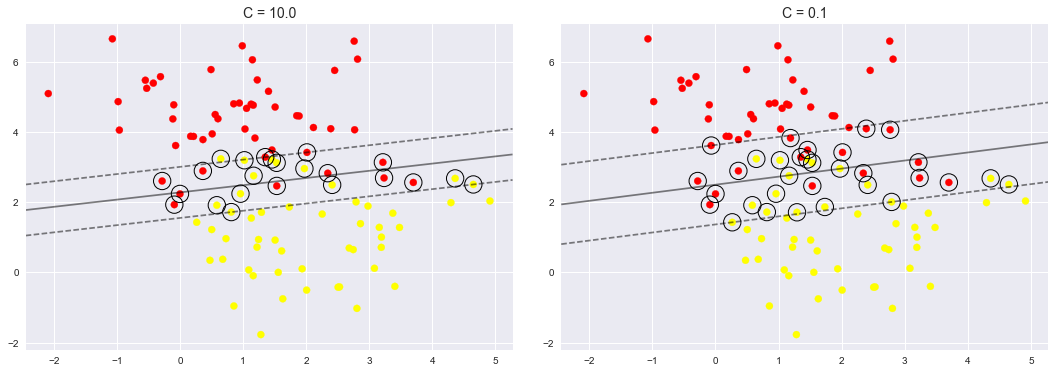

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value for $C$ depends on the dataset. Methods like grid-search or bayeasian optimization allow to automatically find well performing parameters.

# Example: Face recognition

We want to build a face recognition system.

### Dataset

In [22]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


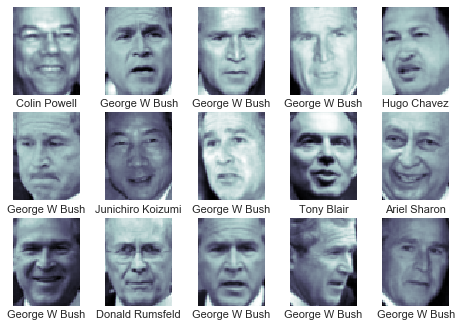

In [23]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each sample is a 62 x 47 pixel image (~3000 features). We'll reduce that to 150 by applying a PCA dimensionality reduction (which will be subject to an upcoming lecture).

In [32]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(svd_solver='randomized', n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced', C=10, gamma=0.0001, )
model = make_pipeline(pca, svc)

 We split the data into a training and testing set:

In [30]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

Then we fit the model:

In [34]:
model.fit(Xtrain, ytrain)

Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=150, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=True)), ('svc', SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Predict the labels of the test set:

In [35]:
yfit = model.predict(Xtest)

Let's examine the results.

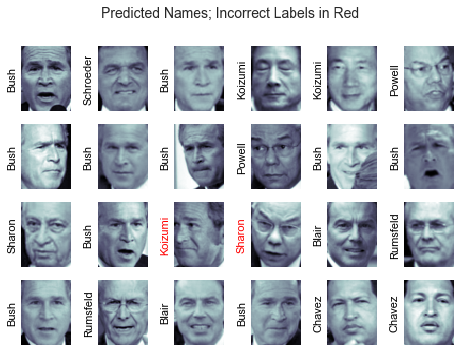

In [36]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

/home/user/projekte/anaconda3/envs/ipynb/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/user/projekte/anaconda3/envs/ipynb/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


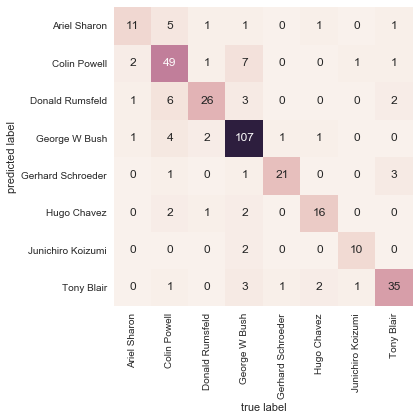

In [37]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');